In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix,f1_score
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
import itertools as it
import time as time
import xgboost as xgb
import seaborn as sns

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Distribution of response
*By Jackson Bremen & Lucy Han*

In [24]:
#data loading
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

data = pd.read_csv('../census-income.data',header=None)
data.columns=column_names

data['>50K'] = data['income'].apply(lambda x: 1 if '+' in x else 0)
target_count = data['>50K'].value_counts()

In [25]:
#visualizing response distribution
target_count = pd.DataFrame({'Income': target_count.index,'Count': target_count.values})
target_count = target_count.set_index('Income')
#Add normalized column
target_count['Percentage'] = 100*target_count['Count']/target_count['Count'].sum()
target_count

,Count,Percentage
Income,,
0,187141,93.794199
1,12382,6.205801


<AxesSubplot:title={'center':'Count (target)'}, xlabel='Income'>

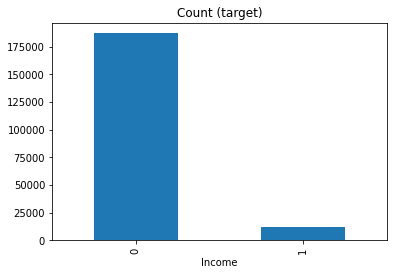

In [26]:
target_count['Count'].plot(kind='bar', title='Count (target)')

### Data cleaning
*By *

In [5]:
#...Code with comments...#

# Imputing missing values #

### Data preparation
*By name*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [6]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [7]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis
*By Lucy Han and Jackson Bremen*

In [27]:
df = pd.read_csv('../data/census-income.data', header=None)
df.head(2)
data = pd.read_csv('../census-income.data',header=None)
data.columns=column_names
data['income'] = data['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

In [28]:
categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']
continuous_predictors = ['age', 'wage_hr','cap_gain', 'cap_loss', 'dividend','inst_weight', 
                         'num_ppl_worked', 'weeks_worked']

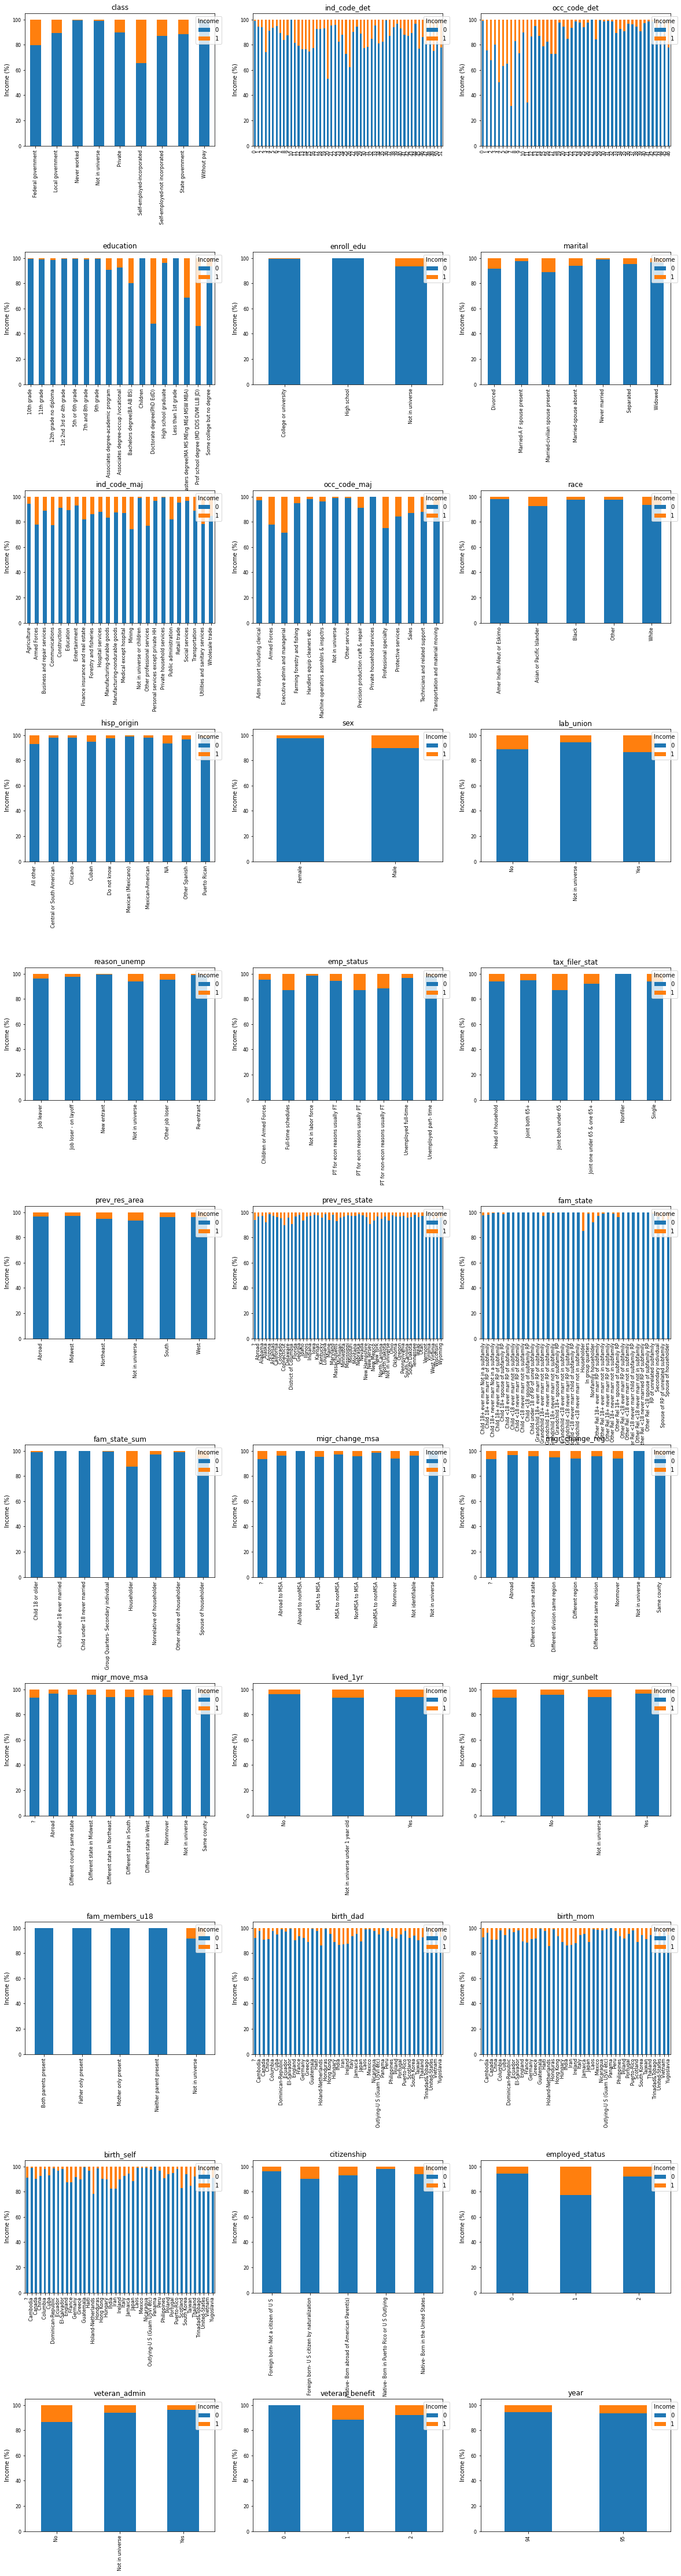

In [29]:
# Plotting categorical variables against response
n_rows = 11
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 80))

# Plotting stacked bar plots for categorical predictors
for i, predictor in enumerate(categorical_predictors):
    ax = axs[i // n_cols, i % n_cols]
    grouped_data = data.groupby([predictor, 'income'])['income'].count().unstack()
    totals = grouped_data.sum(axis=1)
    percent_data = grouped_data.div(totals, axis=0) * 100
    percent_data.plot.bar(stacked=True, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('Income (%)')
    ax.set_title(predictor)
    ax.legend(title='Income', loc='upper right', bbox_to_anchor=(1.05, 1))
    ax.tick_params(axis='both', labelsize=8)  

fig.subplots_adjust(hspace=0.8)
plt.show()

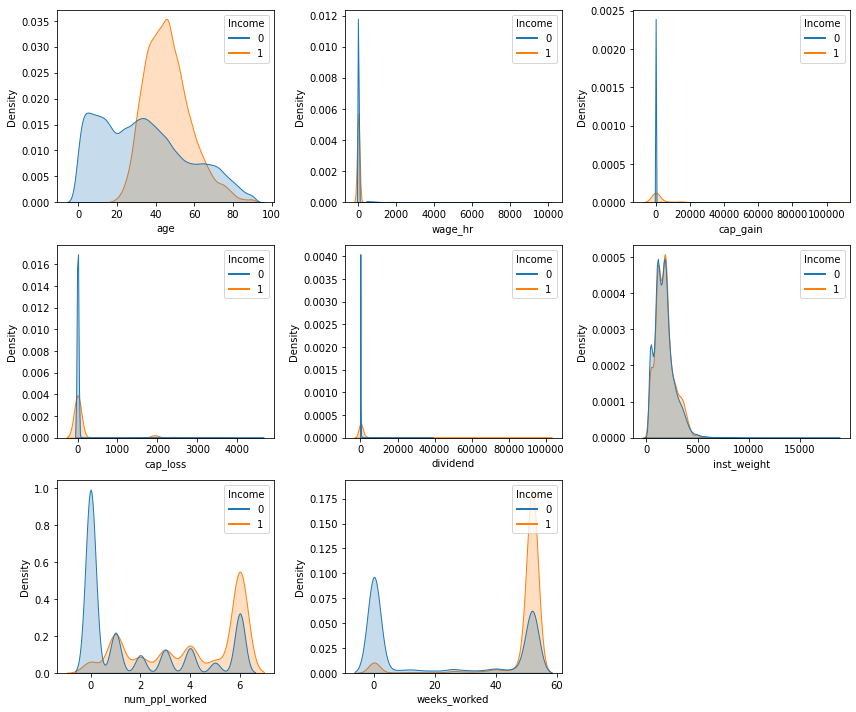

In [30]:
from matplotlib.lines import Line2D

n_rows = 3
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 10))

# Plotting density plots for continuous predictors against response.
for j, predictor in enumerate(continuous_predictors):
    ax = axs[j // n_cols, j % n_cols]
    sns.kdeplot(data=data, x=predictor, hue='income', ax=ax, fill=True, common_norm=False)
    ax.set_xlabel(predictor)
    ax.set_ylabel('Density')
    
    # Create custom legend entries
    legend_entries = []
    for income_value in data['income'].unique():
        legend_entry = Line2D([0],[0], color=sns.color_palette()[income_value], lw=2, label=income_value)
        legend_entries.append(legend_entry)
    ax.legend(handles=legend_entries, title='Income', loc='upper right')

# Removing any unused subplots
for i in range(len(continuous_predictors), n_rows * n_cols):
    if isinstance(axs, np.ndarray):
        fig.delaxes(axs.flatten()[i])
    else:
        fig.delaxes(axs[i // n_cols, i % n_cols])

fig.tight_layout()
plt.show()

In [31]:
sex_grouped_data = data.groupby(['sex', 'income'])['income'].count().unstack()
totals = sex_grouped_data.sum(axis=1)
percent_data = sex_grouped_data.div(totals, axis=0) * 100
# Sort the data by the 1 column
percent_data.sort_values(by=1, inplace=True, ascending=False)

# Round the percentage data to 2 decimal places
percent_data = percent_data.round(2)

# Set the headers to be the income values
percent_data.columns = ['<=50K', '>50K']

percent_data


,<=50K,>50K
sex,,
Male,89.83,10.17
Female,97.44,2.56


In [32]:
sex_grouped_data = data.groupby(['sex', 'income'])['income'].count().unstack()
totals = sex_grouped_data.sum(axis=1)
percent_data = sex_grouped_data.div(totals, axis=0) * 100
# Sort the data by the 1 column
percent_data.sort_values(by=1, inplace=True, ascending=False)

# Round the percentage data to 2 decimal places
percent_data = percent_data.round(2)

# Set the headers to be the income values
percent_data.columns = ['<=50K', '>50K']

percent_data


,<=50K,>50K
sex,,
Male,89.83,10.17
Female,97.44,2.56


## Developing the model: Hyperparameter tuning

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

Put each model in a section of its name and mention the name of the team-member tuning the model. Below is an example:

### MARS
*By Joseph Prette*
This code cannot be run here since it py-earth does not run natively on our machines - only in Colab.

In [ ]:
# Due to the time inneficiency of MARS and limited duration to prepare this,
# a random subsample of 5,000 datapoints are taken for the training data.
train_sample = train.sample(5000)
train_dum_sample = pd.get_dummies(train_sample)
y_train_sampled = train_dum_sample['>50K']
X_train_sampled = train_dum_sample.drop(['>50K'], axis = 1)

# reshape X_train and show dimensions
y_train_sampled = np.array(y_train_sampled).reshape(-1, 1)
print(y_train_sampled.shape)

# show y_train dimensions and confirm same number of predictors
print(X_train_sampled.shape)


# optmization
terms = [10, 20, 50, 100, 250, 500]
degrees = [10, 20, 50, 100, 150]


scoring_df = pd.DataFrame(columns = ['max_degree', 'max_terms', 'accuracy', 'recall'])
curr_row = 0

for term in terms:
  for degree in degrees:
    
    # Create model
    mars = Earth(max_degree = degree, max_terms = term)
    mars.fit(X_train_sampled, y_train_sampled.astype(bool))

    # Get Scores
    y_train_pred = mars_model.predict(X_train_sampled)
    y_train_pred = np.round(y_train_pred).astype(bool)
    tn, fp, fn, tp = confusion_matrix(y_train_sampled, y_train_pred).ravel()

    accuracy = np.mean(y_train_pred == y_train_sampled)
    recall = tp / (tp + fn)

    # Fill in DataFrame Values
    scoring_df.loc[curr_row, ['max_degree', 'max_terms', 'accuracy', 'recall']] = [degree, term, accuracy, recall]

    # Update curr_row
    curr_row = curr_row + 1


# modeling
mars_model2 = Earth(max_degree = 2, max_terms = 20)
mars_model2.fit(X_train, y_train_sampled.astype(bool))

y_test_pred = mars_model2.predict(X_test)
y_test_pred = np.round(y_test_pred).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_train_pred).ravel()

accuracy = np.mean(y_train_pred == y_train_sampled)
print('Accuracy:', accuracy)

recall = tp / (tp + fn)
print('Recall:', recall)

# this resulting in:
# Accuracy: 0.911
# Recall: 0.7203947368421053

### Adaboost
*By Jackson Bremen*

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [2]:
column_names=[
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year', 'income']

predictors = [
    'age', 'class', 'ind_code_det', 'occ_code_det', 'education', 'wage_hr', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'cap_gain', 'cap_loss', 'dividend', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'inst_weight', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'num_ppl_worked', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'weeks_worked', 'year']

categorical_predictors = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'migr_change_msa', 'migr_change_reg', 'migr_move_msa', 'lived_1yr',
    'migr_sunbelt', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']

train_data = pd.read_csv('../census-income.data',header=None)

test_data = pd.read_csv('../census-income.test',header=None)

In [3]:
def get_metrics(y_test, y_pred):
    print("confusion_matrix:")
    # print(confusion_matrix(y_test, y_pred))

    # Plot confusion matrix, showing the values in each cell
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm, cmap=plt.cm.Blues)
    # Show the values
    for x in range(cm.shape[0]):
        for y in range(cm.shape[1]):
            plt.text(x, y, str(cm[x,y]), va='center', ha='center')

    # Set axes
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100}%")
    print(f"Recall: {recall_score(y_test, y_pred) * 100}%")
    print(f"Precision: {precision_score(y_test, y_pred) * 100}%")
    
def find_threshold(y_pred, y_true):
    p, r, thresholds = precision_recall_curve(y_true, y_pred)

    f1 = 2 * (p[:-1] * r[:-1]) / (p[:-1] + r[:-1])

    # Plot the model precision-recall curve

    df = pd.DataFrame({'Precision': p[:-1], 'Recall': r[:-1], 'Threshold': thresholds})

    # USe f1 to find thresh
    threshold = df.iloc[f1.argmax()]['Threshold']

    df.plot(x="Threshold", y=["Precision", "Recall"], figsize=(10, 5), grid=True)
    # Add a vertical line at the threshold that maximizes F1 score
    plt.vlines(threshold, 0, 1, linestyle='--')

    return threshold


In [4]:
train_data = pd.read_csv('../census-income.data',header=None)

test_data = pd.read_csv('../census-income.test',header=None)

# print number of rows in test and train data
print(f"Train data: {train_data.shape[0]} rows")
print(f"Test data: {test_data.shape[0]} rows")

# Add a column for 'test'
test_data['test'] = 1
train_data['test'] = 0

# Concatenate the dataframes

data = pd.concat([train_data, test_data])

data.columns = column_names + ['test']

# Replace ? with NaN
data.replace('?', np.nan, inplace=True)
data.replace(' ?', np.nan, inplace=True)

data.dropna(inplace=True)

data.drop('inst_weight', axis=1, inplace=True)

data['>50K'] = data['income'].apply(lambda x: 1 if '+' in x else 0)



Train data: 199523 rows
Test data: 99762 rows


In [5]:
edu_freqs = data.groupby('education')['>50K'].sum()
edu_freqs.sort_values(ascending=False, inplace=True)

# Take the top 6 values and set the rest to 'Other'
top_edu = edu_freqs.index[:6].tolist()

data['education'] = data['education'].apply(lambda x: x if x in top_edu else 'Other')

# Do the same for the birth dad and birth mom columns
birth_dad_freqs = data.groupby('birth_dad')['>50K'].sum()
birth_dad_freqs.sort_values(ascending=False, inplace=True)

# Get the top 6 values
top_birth_dad = birth_dad_freqs.index[:6].tolist()

data['birth_dad'] = data['birth_dad'].apply(lambda x: x if x in top_birth_dad else 'Other')

birth_mom_freqs = data.groupby('birth_mom')['>50K'].sum()
birth_mom_freqs.sort_values(ascending=False, inplace=True)

# Get the top 6 values
top_birth_mom = birth_mom_freqs.index[:6].tolist()

data['birth_mom'] = data['birth_mom'].apply(lambda x: x if x in top_birth_mom else 'Other')

# Do the same for the birth self column
birth_self_freqs = data.groupby('birth_self')['>50K'].sum()
birth_self_freqs.sort_values(ascending=False, inplace=True)

# Get the top 6 values
top_birth_self = birth_self_freqs.index[:6].tolist()

data['birth_self'] = data['birth_self'].apply(lambda x: x if x in top_birth_self else 'Other')

# Do the same for the fam_state_sum column
fam_state_sum_freqs = data.groupby('fam_state_sum')['>50K'].sum()
fam_state_sum_freqs.sort_values(ascending=False, inplace=True)

# Get the top 6 values
top_fam_state_sum = fam_state_sum_freqs.index[:3].tolist()

data['fam_state_sum'] = data['fam_state_sum'].apply(lambda x: x if x in top_fam_state_sum else 'Other')

# Do the same for the fam_state column
fam_state_freqs = data.groupby('fam_state')['>50K'].sum()
fam_state_freqs.sort_values(ascending=False, inplace=True)

# Get the top 5 values
top_fam_state = fam_state_freqs.index[:5].tolist()

data['fam_state'] = data['fam_state'].apply(lambda x: x if x in top_fam_state else 'Other')


In [6]:
# Convert the ind_code column to a categorical column
data['ind_code_det'] = data['ind_code_det'].astype('category')
data['occ_code_det'] = data['occ_code_det'].astype('category')



In [7]:
# Get dummy variables for the categorical columns
data = pd.get_dummies(data, columns=categorical_predictors, drop_first=True)


In [8]:
# Split the data back into train and test
train_data = data[data['test'] == 0]
test_data = data[data['test'] == 1]

# Drop the test column
train_data = train_data.drop('test', axis=1)
test_data = test_data.drop('test', axis=1)

# Split the data into X and y
X_train = train_data.drop('>50K', axis=1)
X_train = X_train.drop('income', axis=1)
y_train = train_data['>50K']

X_test = test_data.drop('>50K', axis=1)
X_test = X_test.drop('income', axis=1)
y_test = test_data['>50K']

Around 12 rounds of hyperparameter tuning were performed for the Adaboost model, starting with very wide ranges for the hyperparameters, then narrowing them down. This is the final round of hyperparameter tuning. Throughout, a mix of GridSearchCV and RandomizedGridSearch were used. 

The exclusion of the other rounds of tuning is deliberate, and is done for brevity.

In [ ]:
# It took several passes of gridsearch to get the best parameters, but this is the final 
# round of gridsearch
ada = AdaBoostClassifier(random_state=42)

param_dist = {'learning_rate': [0.03, 0.05, 0.075, 1],
                'n_estimators': [750, 850, 900, 1000, 1050, 1100],
                'estimator__max_depth': [1, 2, 5],
                'estimator__min_samples_split': [2, 4, 6, 8],
                'estimator__min_samples_leaf': [1, 2, 4, 6, 8],
                'estimator': [DecisionTreeClassifier()]
                }

ada_cv_v2 = GridSearchCV(ada, param_dist, cv=2, scoring='roc_auc', n_iter=25, random_state=42, verbose=1, n_jobs=-1)

ada_cv_v2.fit(X_train, y_train)

ada_cv_v2.best_params_

0.4946572090646148

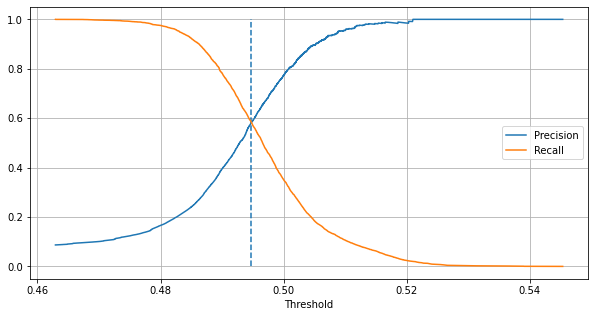

In [10]:
# Train a model with the best parameters
from sklearn.tree import DecisionTreeClassifier
best_ada = AdaBoostClassifier(n_estimators=1000, learning_rate=0.05, 
                              base_estimator=DecisionTreeClassifier(max_depth=1, min_samples_split=2, min_samples_leaf=6, max_leaf_nodes=3), 
                              random_state=42)


best_ada.fit(X_train, y_train)

y_pred_probs_train = best_ada.predict_proba(X_train)[:, 1]

threshold = find_threshold(y_pred_probs_train, y_train)

threshold


We found an ideal threshold using the default ROC curve, then manually adjusted it to find the maximum value of recall while keeping accuracy over 90%. We then used this threshold to predict the test data.

In [11]:
y_pred_probs_test = best_ada.predict_proba(X_test)[:, 1]

confusion_matrix:
Accuracy: 90.05296364288577%
Recall: 83.45136041744317%
Precision: 34.39852511906591%


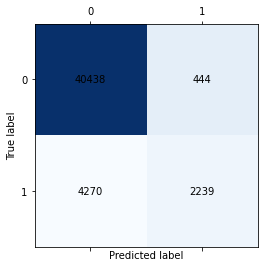

In [17]:
y_pred_test = y_pred_probs_test >= 0.4887

get_metrics(y_test, y_pred_test)

#### Adaboost Feature importances

In [18]:
most_importants = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_ada.feature_importances_})
most_importants.sort_values('Importance', ascending=False, inplace=True)
most_importants.head(10)

,Feature,Importance
1,wage_hr,0.069
4,dividend,0.057
0,age,0.051
2,cap_gain,0.046
5,num_ppl_worked,0.044
113,education_ High school graduate,0.043
3,cap_loss,0.040
117,education_Other,0.034
6,weeks_worked,0.032
176,sex_ Male,0.032


### Decision Tree with ccp tuning
*By Chanel Sun*

In [ ]:
# balance training data
from sklearn.utils import resample
train_0 = train[train['>50K'] == 0]
train_1 = train[train['>50K'] == 1]
sampled_train_0 = resample(train_0, n_samples=int(0.08 * len(train_0)), random_state=1)
train = pd.concat([sampled_train_0, train_1])

train_distr = Counter(train['>50K'])
print(train_distr)

Counter({0: 14971, 1: 12382})


In [ ]:
# one-hot encoding 
combined_X = pd.concat([X_train, X_test], axis=0)
X_encoded = pd.get_dummies(combined_X, columns=categorical_predictors, dtype=int)
X_train_encoded = X_encoded.iloc[:len(X_train)]
X_test_encoded = X_encoded.iloc[len(X_train):]

In [ ]:
#Removing quasi-constant features
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
sel.fit(X_train_encoded)  # fit finds the features with low variance
sel_idx = X_train_encoded.columns[sel.get_support()]
# finally we can print the quasi-constant features
print(
    len([
        x for x in X_train_encoded.columns
        if x not in X_train_encoded.columns[sel.get_support()]
    ]))

[x for x in X_train_encoded.columns if x not in X_train_encoded.columns[sel.get_support()]]
# we can then remove the features from training and test set
X_train_encoded = sel.transform(X_train_encoded)
X_test_encoded = sel.transform(X_test_encoded)

189

In [ ]:
#Defining the object to build a regression tree
dt_model1 = DecisionTreeClassifier(random_state=1) 
#Fitting the regression tree to the data
dt_model1.fit(X_train_encoded, y_train)
print(dt_model1.get_n_leaves())
print(dt_model1.get_depth())

3336
47


In [ ]:
# Course Grid Search
param_grid = {    
    'max_depth': range(5,51,5),
    'max_leaf_nodes': range(5,3400,100),
    'max_features': range(10, 180, 10)
}

#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=30)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train_encoded, y_train)

# make the predictions
y_pred = grid_search.predict(X_test_encoded)


Fitting 30 folds for each of 10 candidates, totalling 300 fits


In [ ]:
print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train_encoded, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test_encoded, y_test))
print('Train accuracy : %.3f'%grid_search.best_estimator_.score(X_train_encoded, y_train))
print('Test accuracy : %.3f'%grid_search.best_estimator_.score(X_test_encoded, y_test))
print('Best accuracy Through Grid Search : %.3f'%grid_search.best_score_)

y_train_pred = grid_search.best_estimator_.predict(X_train_encoded)
train_recall = recall_score(y_train, y_train_pred)
print('Train recall : %.3f' % train_recall)
y_test_pred = grid_search.best_estimator_.predict(X_test_encoded)
test_recall = recall_score(y_test, y_test_pred)
print('Test recall : %.3f' % test_recall)

print('Best params for recall')
print(grid_search.best_params_)

Train accuracy : 0.928
Test accuracy : 0.851
Train accuracy : 0.928
Test accuracy : 0.851
Best accuracy Through Grid Search : 0.836
Train recall : 0.928
Test recall : 0.847
Best params for recall
{'max_leaf_nodes': 908, 'max_features': 167, 'max_depth': 38}


In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,param_max_features,param_max_depth,params,split0_test_precision,split1_test_precision,...,split23_test_recall,split24_test_recall,split25_test_recall,split26_test_recall,split27_test_recall,split28_test_recall,split29_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.506081,0.046862,0.006338,0.003083,2505,90,50,"{'max_leaf_nodes': 2505, 'max_features': 90, '...",0.836186,0.823113,...,0.825243,0.842233,0.805825,0.813107,0.781553,0.764563,0.800971,0.821991,0.021858,7
1,0.272320,0.040830,0.004295,0.002692,305,90,35,"{'max_leaf_nodes': 305, 'max_features': 90, 'm...",0.810811,0.819222,...,0.881068,0.856796,0.854369,0.810680,0.800971,0.830097,0.842233,0.848245,0.021220,2


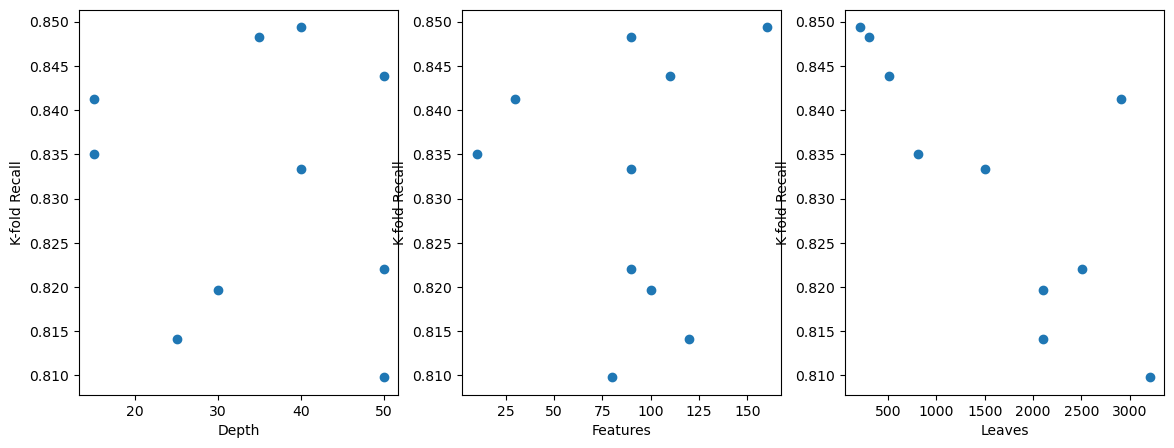

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, cv_results.mean_test_recall, 'o')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold Recall')
axes[1].plot(cv_results.param_max_features, cv_results.mean_test_recall, 'o')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('K-fold Recall');
axes[2].plot(cv_results.param_max_leaf_nodes, cv_results.mean_test_recall, 'o')
axes[2].set_xlabel('Leaves')
axes[2].set_ylabel('K-fold Recall');

In [ ]:
#Finer Grid 
# From Course Grid {'max_leaf_nodes': 905, 'max_features': 170, 'max_depth': 40}
param_grid = {    
    'max_depth': range(38, 45,2),
    'max_leaf_nodes': range(900,910,2),
    'max_features': range(165, 175, 2)
}

#Grid search to optimize parameter values
import time as time
start_time = time.time()
skf = StratifiedKFold(n_splits=20)#The folds are made by preserving the percentage of samples for each class.

#Minimizing FNR is equivalent to maximizing recall
grid_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), param_grid, scoring=['precision','recall'], 
                           refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train_encoded, y_train)

Fitting 20 folds for each of 10 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=20, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
                   param_distributions={'max_depth': range(38, 45, 2),
                                        'max_features': range(165, 175, 2),
                                        'max_leaf_nodes': range(900, 910, 2)},
                   refit='recall', scoring=['precision', 'recall'],
                   verbose=True)

In [ ]:
print(grid_search.best_params_)

{'max_leaf_nodes': 908, 'max_features': 167, 'max_depth': 38}


Accuracy:  85.0774844129027
ROC-AUC:  0.8723779056744277
Precision:  0.2731870079766436
Recall:  0.8470740381506627


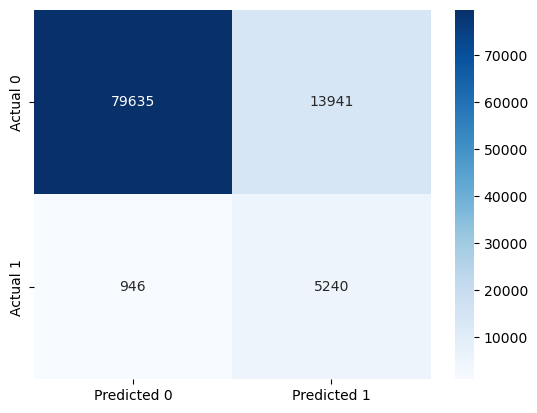

In [ ]:
dt_final = grid_search.best_estimator_

# Performance metrics computation 
#Computing the accuracy
y_pred = dt_final.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = dt_final.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

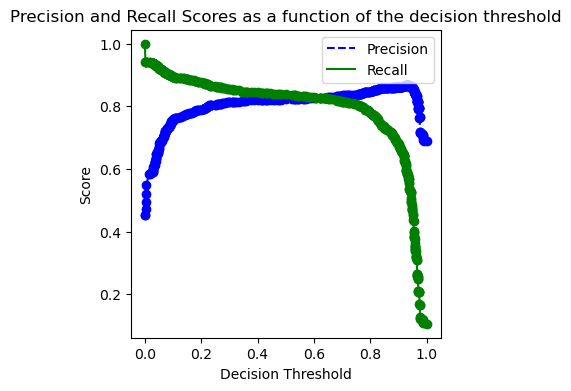

In [ ]:
#threshold tuning 
cross_val_ypred = cross_val_predict(dt_final, X_train_encoded, 
                                              y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  92.73571454685043
ROC-AUC:  0.9711942523542068
Precision:  0.9167668992061583
Recall:  0.9233564852204813


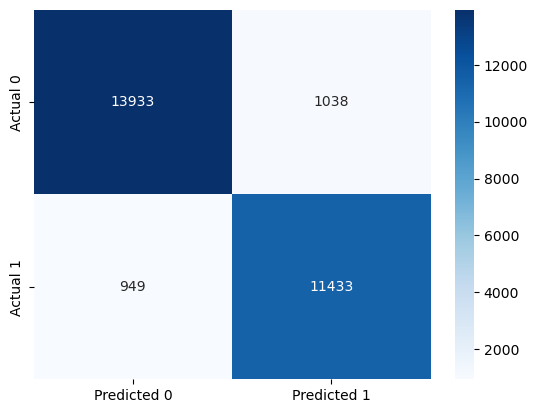

In [ ]:
#threshold tuning 
#train
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.55

y_pred_prob = dt_final.predict_proba(X_train_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  85.43934564262946
ROC-AUC:  0.8723779056744277
Precision:  0.2777896195246723
Recall:  0.8427093436792757


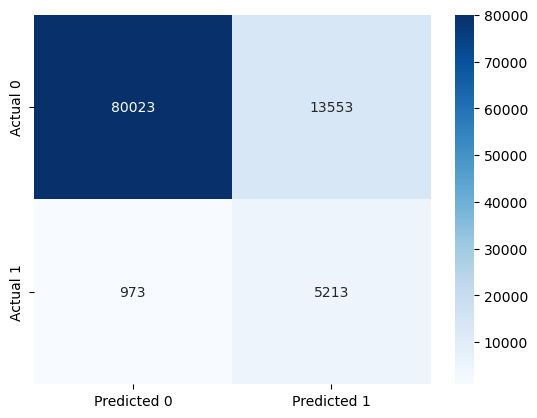

In [ ]:
#threshold tuning 
#test
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.55

y_pred_prob = dt_final.predict_proba(X_test_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
# decision tree cost complexity pruning 
ccp_model = DecisionTreeClassifier(random_state = 1)#model without any restrictions
path= ccp_model.cost_complexity_pruning_path(X_train_encoded, y_train)# Compute the pruning path during Minimal Cost-Complexity Pruning.

In [ ]:
alphas=path['ccp_alphas']
len(alphas)

1465

In [ ]:
#Grid search to optimize parameter values
skf = StratifiedKFold(n_splits=30)
grid_search = RandomizedSearchCV(DecisionTreeClassifier(random_state = 1), param_distributions = {'ccp_alpha':alphas}, 
                                                  scoring=['precision','recall','accuracy'], 
                                                  refit="recall", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train_encoded, y_train)

# make the predictions
y_pred = grid_search.predict(X_test_encoded)
print('Best params for recall')
print(grid_search.best_params_)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
Best params for recall
{'ccp_alpha': 0.00027209681519906916}


In [ ]:
# Model with the optimal value of 'ccp_alpha'
ccp_model = DecisionTreeClassifier(ccp_alpha=0.00012957283640572484,random_state=1)
ccp_model.fit(X_train_encoded, y_train)

DecisionTreeClassifier(ccp_alpha=0.00012957283640572484, random_state=1)

Accuracy:  86.00268639361681
ROC-AUC:  0.9255800790191587
Precision:  0.28827308362369336
Recall:  0.8559650824442289


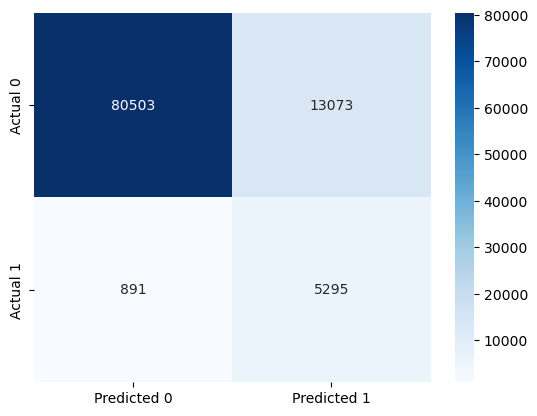

In [ ]:
# Performance metrics computation 
#Computing the accuracy
y_pred = ccp_model.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = ccp_model.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

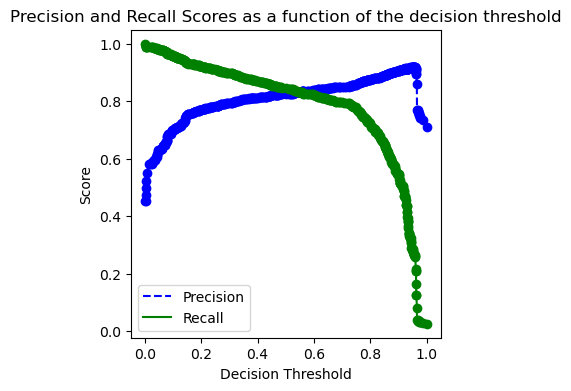

In [ ]:
#threshold tuning 
cross_val_ypred = cross_val_predict(ccp_model, X_train_encoded, 
                                              y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  88.31572405220633
ROC-AUC:  0.9459728155206566
Precision:  0.8697472226694574
Recall:  0.8725569374899047


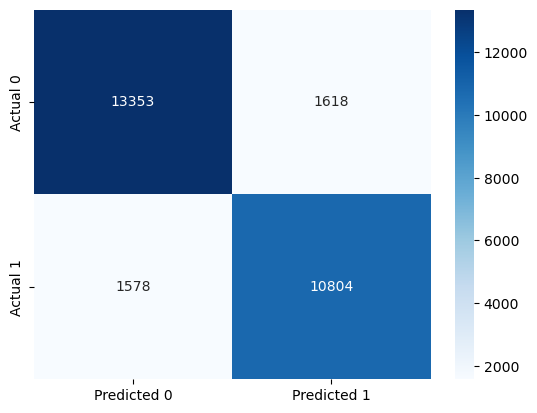

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.55

y_pred_prob = ccp_model.predict_proba(X_train_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  86.35452376656443
ROC-AUC:  0.9255800790191587
Precision:  0.2930851952972642
Recall:  0.850307145166505


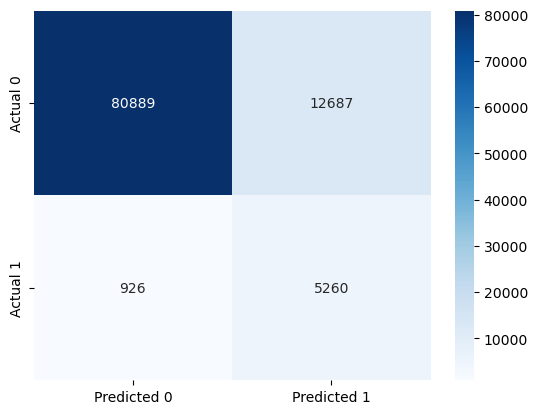

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.55

y_pred_prob = ccp_model.predict_proba(X_test_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

### Random Forest
*By Chanel Sun*

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

import itertools as it
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

import itertools as it
import time as time

In [ ]:
# Random Forest Base Model 
rf_model1 = RandomForestClassifier(random_state=1)
rf_model1.fit(X_train_encoded, y_train)
y_pred_train = rf_model1.predict(X_train_encoded)
print(accuracy_score(y_train, y_pred_train), recall_score(y_train, y_pred_train))
y_pred = rf_model1.predict(X_test_encoded)
print(accuracy_score(y_test, y_pred), recall_score(y_test, y_pred))

0.9999268818776734 0.9999192376029721
0.8682464264950582 0.8839314581312642


In [ ]:
# Feature Importance 
feature_importance = rf_model1.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_encoded.columns, 'Importance': feature_importance})
feature_importance_df.head(10)

,Feature,Importance
0,age,0.071339
1,wage_hr,0.006194
2,cap_gain,0.028804
3,cap_loss,0.008999
4,dividend,0.061776
5,inst_weight,0.043916
6,num_ppl_worked,0.055869
7,weeks_worked,0.065710
8,class_ Federal government,0.002034
9,class_ Local government,0.002438


In [ ]:
# Drop features with importance less than 0.001
imp_features = feature_importance_df[feature_importance_df['Importance'] >= 0.001]['Feature']
X_train_filtered = X_train_encoded[imp_features]
X_test_filtered = X_test_encoded[imp_features]
X_train_filtered.shape

(27353, 161)

In [ ]:
#Course Grid
parameters = {'max_depth': range(5,51,5),
              'max_leaf_nodes': range(5,3400,100),
              'max_features': range(10, 180, 10), 
              'n_estimators': range(100, 501, 100),
             'max_samples':[0.25,0.5,0.75]}
cv = KFold(n_splits = 20,shuffle=True,random_state=1)
rf_model2 = RandomizedSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1), parameters, 
                     scoring=['accuracy','recall'], refit='recall',
                            cv=cv, n_jobs=-1, verbose = True)
rf_model2.fit(X_train_encoded, y_train)
print("Best Accuracy:", rf_model2.best_score_, "Best Parameters:",rf_model2.best_params_)

Fitting 20 folds for each of 10 candidates, totalling 200 fits
Best Accuracy: 0.8928916339397732 Best Parameters: {'n_estimators': 400, 'max_samples': 0.5, 'max_leaf_nodes': 3205, 'max_features': 10, 'max_depth': 20}


In [ ]:
#Finer Grid 
# From Course Grid {'n_estimators': 400, 'max_samples': 0.5, 'max_leaf_nodes': 3205, 'max_features': 10, 'max_depth': 20}
parameters = {'max_depth':range(18,23),
              'max_leaf_nodes':range(3200,3209,3),
              'max_features':range(8,12), 
             'max_samples':[0.45, 0.5, 0.55]}
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
rf_model2 = RandomizedSearchCV(RandomForestClassifier(random_state=1, n_jobs=-1, n_estimators = 300), parameters, 
                     scoring=['accuracy','recall'], refit='recall',
                            cv=cv, n_jobs=-1, verbose = True)
rf_model2.fit(X_train_encoded, y_train)
print("Best Accuracy:", rf_model2.best_score_, "Best Parameters:",rf_model2.best_params_)#Course Grid

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Accuracy: 0.895853062890934 Best Parameters: {'max_samples': 0.55, 'max_leaf_nodes': 3203, 'max_features': 8, 'max_depth': 19}


Accuracy:  84.4790601631884
ROC-AUC:  0.944397148990842
Precision:  0.27244248653940284
Recall:  0.899773682508891


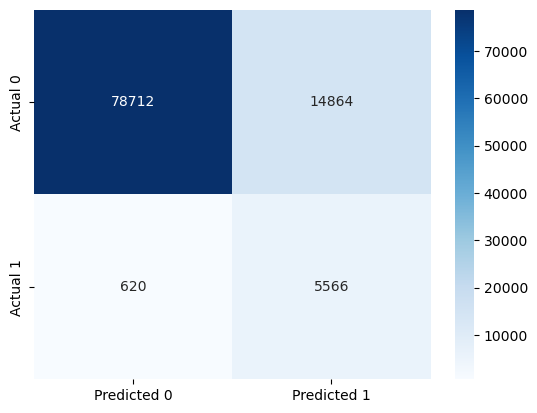

In [ ]:
rf_final = rf_model2.best_estimator_

# Performance metrics computation 
#Computing the accuracy
y_pred = rf_final.predict(X_test_encoded)
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
y_pred_prob = rf_final.predict_proba(X_test_encoded)[:,1]
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

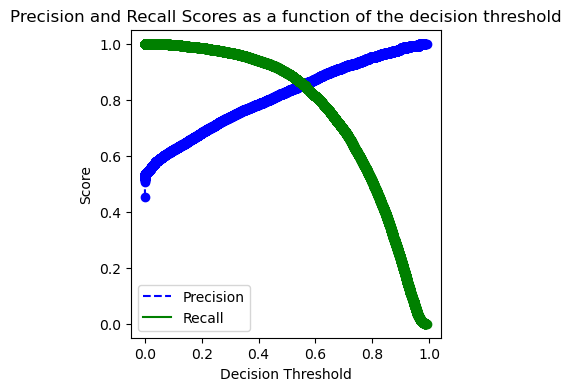

In [ ]:
#threshold tuning 
cross_val_ypred = cross_val_predict(rf_final, X_train_encoded, 
                                              y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(4, 4))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  91.92410338902496
ROC-AUC:  0.978756964913839
Precision:  0.9049438738953905
Recall:  0.9180261670166371


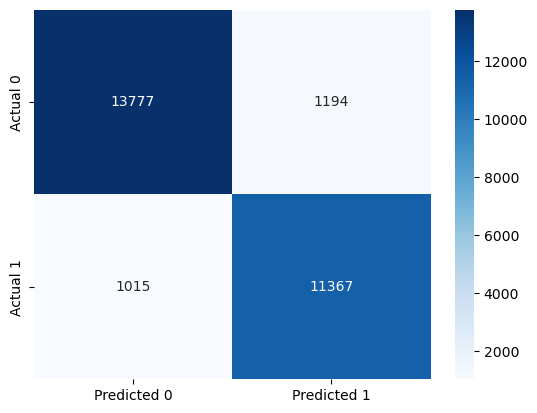

In [ ]:
# train
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.56

y_pred_prob = rf_final.predict_proba(X_train_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Accuracy:  87.51428399591028
ROC-AUC:  0.944397148990842
Precision:  0.3149132128940843
Recall:  0.8622696411251213


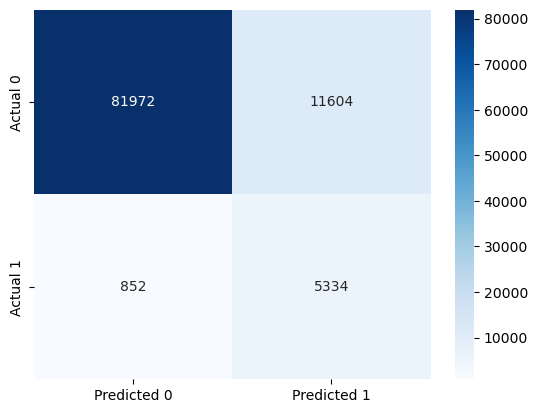

In [ ]:
#test 
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.56

y_pred_prob = rf_final.predict_proba(X_test_encoded)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
# Feature Importance 
feature_scores = pd.Series(rf_final.feature_importances_, index=X_train_encoded.columns).sort_values(ascending=False)
feature_scores

weeks_worked                         0.065939
age                                  0.060137
dividend                             0.055038
num_ppl_worked                       0.053445
sex_ Female                          0.031283
                                       ...   
occ_code_maj_ Protective services    0.000493
ind_code_det_12                      0.000477
ind_code_det_24                      0.000456
race_ Other                          0.000453
hisp_origin_ Puerto Rican            0.000411
Length: 189, dtype: float64

### XGBoost
*By Lucy Han*

In [12]:
#data preparation for XGBoost
data_xgb = pd.read_csv('../data/census-income.data', header=None)
data_xgb = data_xgb.replace('?', np.nan)
data_xgb = data_xgb.replace(' ?', np.nan)
data_xgb.columns=column_names
#removed 4 columns with 50% missing value. Not realistic nor meaningful to impute these values.
data_xgb.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
data_xgb.dropna(inplace=True)
data_xgb.drop('inst_weight', axis=1, inplace=True)

In [13]:
train_xgb = data_xgb.copy()
train_xgb['income'] = train_xgb['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

test_xgb = pd.read_csv('../census-income.test',header=None)
test_xgb.columns=column_names
test_xgb.drop(['migr_change_msa','migr_change_reg','migr_move_msa','migr_sunbelt'],axis = 1,inplace=True)
test_xgb.dropna(inplace=True)
test_xgb.drop('inst_weight', axis=1, inplace=True)
test_xgb['income'] = test_xgb['income'].apply(lambda x: 1 if x == ' 50000+.' else 0)

In [15]:
#label encoding. Have tried on-hot encoding, no difference in model performance. Thus used label to keep things cleaner
label = [
    'class', 'ind_code_det', 'occ_code_det', 'education', 'enroll_edu', 'marital',
    'ind_code_maj', 'occ_code_maj', 'race', 'hisp_origin', 'sex', 'lab_union', 'reason_unemp',
    'emp_status', 'tax_filer_stat', 'prev_res_area', 'prev_res_state',
    'fam_state', 'fam_state_sum', 'lived_1yr', 'fam_members_u18', 'birth_dad', 'birth_mom', 'birth_self', 'citizenship',
    'employed_status', 'veteran_admin', 'veteran_benefit', 'year']
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
for pred in label:
    train_xgb[pred] = lbl.fit_transform(train_xgb[pred])
    test_xgb[pred] = lbl.fit_transform(test_xgb[pred])
    train_xgb[pred] = train_xgb[pred]
train_xgb.head(2)

,age,class,ind_code_det,occ_code_det,education,wage_hr,enroll_edu,marital,ind_code_maj,occ_code_maj,...,birth_dad,birth_mom,birth_self,citizenship,employed_status,veteran_admin,veteran_benefit,weeks_worked,year,income
0,73,3,0,0,12,0,2,6,14,6,...,39,39,39,4,0,1,2,0,1,0
1,58,6,4,34,16,0,2,0,4,8,...,39,39,39,4,0,1,2,52,0,0


In [27]:
def decision_threshold(model):
    threshold_hyperparam_vals = np.arange(0, 1.01, 0.01)

    predicted_class = cross_val_predict(model, X_train_xgb, y_train_xgb, cv=5)
    predicted_probability = model.predict_proba(X_train_xgb)

    results = []

    for threshold_prob in threshold_hyperparam_vals:
        predicted_class = (predicted_probability[:,1] > threshold_prob).astype(int)
        accuracy = accuracy_score(y_true=y_train_xgb,y_pred=predicted_class)
        recall = recall_score(y_true=y_train_xgb,y_pred=predicted_class)
        results.append({'Threshold': threshold_prob, 'Accuracy': accuracy, 'Recall': recall})
    df_results=pd.DataFrame(results)
    return df_results

def model_performance(model_opt,opt_threshold):
    train_predictions = (model_opt.predict_proba(X_train_xgb)[:, 1] > opt_threshold).astype(int)
    test_predictions = (model_opt.predict_proba(X_test_xgb)[:, 1] > opt_threshold).astype(int)

    train_accuracy = accuracy_score(y_true=y_train_xgb, y_pred=train_predictions)
    train_recall = recall_score(y_true=y_train_xgb, y_pred=train_predictions)
    train_precision = precision_score(y_true=y_train_xgb, y_pred=train_predictions)
    test_accuracy = accuracy_score(y_true=y_test_xgb, y_pred=test_predictions)
    test_recall = recall_score(y_true=y_test_xgb, y_pred=test_predictions)
    test_precision = precision_score(y_true=y_test_xgb, y_pred=test_predictions)
    
    print("Training accuracy:", train_accuracy)
    print("Training recall:", train_recall)
    print("Test accuracy:", test_accuracy)
    print("Test recall:", test_recall)

In [20]:
X_train_xgb = train_xgb.drop(['income'],axis = 1)
y_train_xgb = train_xgb.income
X_test_xgb = test_xgb.drop(['income'],axis = 1)
y_test_xgb = test_xgb.income
X_train_xgb.shape

(190561, 36)

In [23]:
#developing naive model for performance comparison
model_xgb_naive = xgb.XGBClassifier(objective='binary:logistic').fit(X_train_xgb,y_train_xgb)
df_naive_xgb = decision_threshold(model_xgb_naive)

In [25]:
filtered_df_xgb_naive = df_naive_xgb[(df_naive_xgb['Accuracy'] >= 0.9) & (df_naive_xgb['Recall'] >= 0.85)]
filtered_df_xgb_naive.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
8,0.08,0.901874,0.912242
9,0.09,0.909047,0.900232
10,0.10,0.915518,0.889508
11,0.11,0.921180,0.879043
12,0.12,0.925656,0.867805
13,0.13,0.930280,0.858712


In [28]:
model_performance(model_xgb_naive,0.08)

Training accuracy: 0.9018739406279355
Training recall: 0.9122415715878871
Test accuracy: 0.9187566408051162
Test recall: 0.7929194956353055


- Decent training results, but testing recall a bit low
- Without scaling imbalanced data and the threshold being 0.08, the naive model is classifying most observations as 0s. 
- This is the reason why we want higher recall, because we prioritize greater opportunities for individuals to achieve wealth, even if some factors may be uncertain or doubtful.

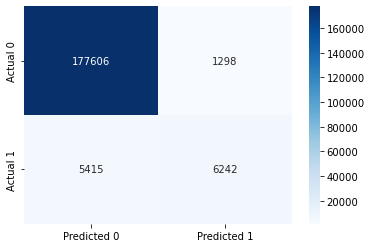

In [32]:
#training confusion matrix for naive xgb model
y_pred_naivetrain = model_xgb_naive.predict(X_train_xgb)
cm = pd.DataFrame(confusion_matrix(y_train_xgb, y_pred_naivetrain), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

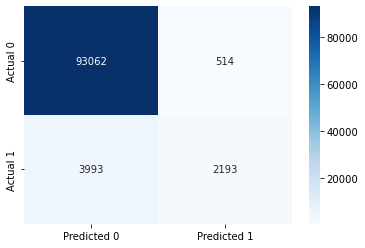

In [30]:
#testing confusion matrix for naive xgb model
y_pred_naive = model_xgb_naive.predict(X_test_xgb)
cm = pd.DataFrame(confusion_matrix(y_test_xgb, y_pred_naive), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [34]:
#calculating scale for hyperparameter: scale_pos_weight
#sum(negative instances) / sum(positive instances)
(y_train_xgb.shape[0]-y_train_xgb.sum())/y_train_xgb.sum()

15.347344942952732

In [36]:
#grid search for final XGB model.
#since random_state is not set, the optimal hyperparam result will be different for every pass.

start_time = time.time()
param_grid = {'max_depth': [8],
              'learning_rate': [0.01,0.1],
              'reg_lambda': [1,10],
              'n_estimators': [500,800,1000],
              'gamma': [1,10],
              'subsample': [0.5],
              'colsample_bytree':[0.5],
              'scale_pos_weight': [15]}

cv = KFold(n_splits=2, shuffle=True)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
                                    param_distributions=param_grid,
                                    verbose=1,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    cv=cv)
optimal_params.fit(X_train_xgb, y_train_xgb)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation score =", optimal_params.best_score_) 
print("Time taken =", round((time.time() - start_time) / 60), " minutes")

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Optimal parameter values = {'subsample': 0.5, 'scale_pos_weight': 15, 'reg_lambda': 10, 'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.5}
Optimal cross validation score = 0.9289413865039315
Time taken = 10  minutes


In [39]:
#final xgb model. Might not have the same hyperparam with above grid, due to randomized search w/o setting random_state
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              max_depth = 8, 
                              learning_rate = 0.01,
                              n_estimators = 1000,
                              reg_lambda = 10, 
                              gamma = 10, 
                              subsample = 0.5, 
                              colsample_bytree=0.5, 
                              scale_pos_weight=15).fit(X_train_xgb,y_train_xgb)
decision_threshold_xgb = decision_threshold(model_xgb)

In [45]:
#tuning decision probability threshold
filtered_df_xgb = decision_threshold_xgb[(decision_threshold_xgb['Accuracy'] >= 0.85) & (decision_threshold_xgb['Recall'] >= 0.85)]
filtered_df_xgb.sort_values('Recall',ascending=False)

,Threshold,Accuracy,Recall
39,0.39,0.851402,0.953676
40,0.40,0.854708,0.952389
41,0.41,0.857505,0.950244
42,0.42,0.860575,0.947757
43,0.43,0.863870,0.945183
44,0.44,0.866914,0.943039
45,0.45,0.870068,0.939350
46,0.46,0.872891,0.936690
47,0.47,0.875882,0.933602
48,0.48,0.878921,0.929141


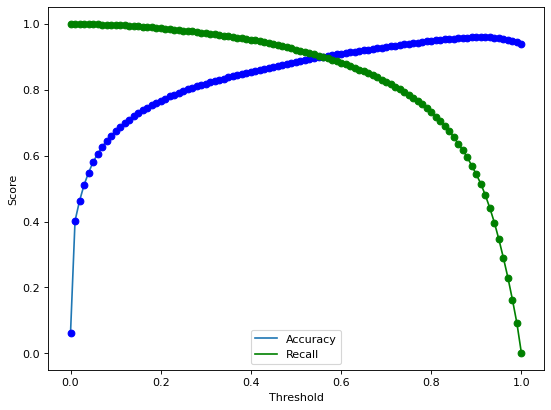

In [41]:
#visualizing different decision threshold combinations
plt.figure(figsize=(8,6),dpi=80)
plt.plot(decision_threshold_xgb['Threshold'],decision_threshold_xgb['Accuracy'],label='Accuracy')
plt.plot(decision_threshold_xgb['Threshold'],decision_threshold_xgb['Accuracy'],'o',color='blue')
plt.plot(decision_threshold_xgb['Threshold'],decision_threshold_xgb['Recall'],label='Recall',color='green')
plt.plot(decision_threshold_xgb['Threshold'],decision_threshold_xgb['Recall'],'o',color='green')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()

In [42]:
#displaying final model performance using selected optimal threshold
model_performance(model_xgb,0.53)

Training accuracy: 0.8926433005704211
Training recall: 0.9111263618426696
Test accuracy: 0.9065977025320262
Test recall: 0.8507921112188813


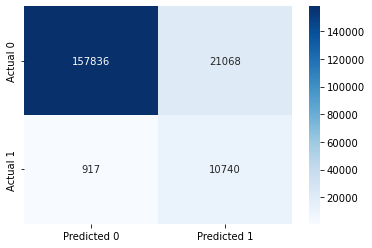

In [43]:
#training cm for final xgb model
y_pred_xgbtrain = model_xgb.predict(X_train_xgb)
cm = pd.DataFrame(confusion_matrix(y_train_xgb, y_pred_xgbtrain), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

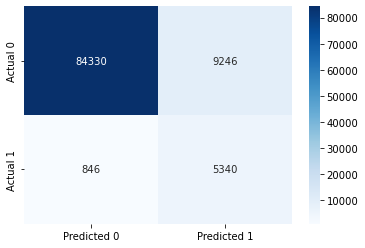

In [46]:
#testing cm for final xgb model
y_pred_xgb = model_xgb.predict(X_test_xgb)
cm = pd.DataFrame(confusion_matrix(y_test_xgb, y_pred_xgb), columns=['Predicted 0', 'Predicted 1'], 
            index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [47]:
#feature importance for XGBoost model
importance = list(model_xgb.feature_importances_)
name = list(model_xgb.feature_names_in_)
df_imp_xgb = pd.DataFrame({'Feature Name':name,'Feature Importance':importance}).sort_values(by='Feature Importance', ascending=False)
df_imp_xgb.head(10)

,Feature Name,Feature Importance
34,weeks_worked,0.161493
12,sex,0.115426
25,num_ppl_worked,0.089569
26,fam_members_u18,0.085098
3,occ_code_det,0.048995
18,dividend,0.046808
16,cap_gain,0.045381
0,age,0.038161
22,fam_state,0.036734
23,fam_state_sum,0.029409


## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.